In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals import joblib
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np
import re

In [3]:
stoplist = set(stopwords.words('english'))
lem=WordNetLemmatizer()

In [4]:
#Function for data cleaning for all datasets
def contentCleaning(df):
    df=df[['content','sentiment']].drop_duplicates()
    filtered_content=df['content']
    filtered_content=[row.lower() for row in filtered_content]
    for i in range(0,len(filtered_content)):
        temp=""
        for w in filtered_content[i].split():           
            while (len(w)>0 and (not re.match("[a-z]",w[len(w)-1]))):
                w=w.replace(w[len(w)-1],"")
            while (len(w)>0 and (not re.match("[a-z]",w[0]))):
                w=w.replace(w[0],"")
            if (w.find("http")!=-1):
                w=""
            if w not in stoplist:
                w=lem.lemmatize(w)
                temp=temp+" "+w
            filtered_content[i]=temp
    df['refined_content']=filtered_content
    return df

In [5]:
def contentCleaning2(df):
    filtered_content=df['content']
    filtered_content=[row.lower() for row in filtered_content]
    for i in range(0,len(filtered_content)):
        temp=""
        for w in filtered_content[i].split():           
            while (len(w)>0 and (not re.match("[a-z]",w[len(w)-1]))):
                w=w.replace(w[len(w)-1],"")
            while (len(w)>0 and (not re.match("[a-z]",w[0]))):
                w=w.replace(w[0],"")
            if (w.find("http")!=-1):
                w=""
            if w not in stoplist:
                w=lem.lemmatize(w)
                temp=temp+" "+w
            filtered_content[i]=temp
    df['refined_content']=filtered_content
    return df

# [Dataset 1] The Affect data by Cecilia Ovesdotter Alm:
http://people.rc.rit.edu/~coagla/affectdata/index.html

The dataset was collected by Cecilia Ovesdotter Alm for her dissertation research based on the Fairy Tale corpus of approximately 185 children stories by Grimms’, Andersen’s and B.Potter’s.
The documents in dataset were annotated with 5 basic emotions Angry-Disgusted (code: 2), Fearful (code: 3), Happy (code: 4), Sad (code: 6), and Surprised (code: 7)
The dataset consists of 3 files: 
- GrimmsAll4labsagree.txt 
- hcand460All4labsagree.txt  
- Potter167All4labsagree.txt

In [6]:
#Load dataset 1 into dataframe df1
path1="T:/MSIM/LIS590TXL - Text Mining/Assignment/Final Project/Data Collection/CeciliaAffectedData/"
file_list={"GrimmsAll4labsagree.txt","hcand460All4labsagree.txt","Potter167All4labsagree.txt"}
df1 = pd.DataFrame()
for i in file_list:
    lines = [line.rstrip('\n') for line in open(path1+i)]
    temp_df = pd.DataFrame([l.split("@") for l in lines],columns=['docno','sentiment_code','content'])
    df1=pd.concat([df1,temp_df],ignore_index=True)

In [7]:
#Data cleaning, specifically for df1
#remove the records do not include sentiment code
df1=df1[pd.isnull(df1['sentiment_code'])==False]
#map sentiment code with sentiment.
df1_dict = {'2':"anger-disgust", '3': "fear", '4': "joy", '6': "sadness", '7': "surprise" }
df1['sentiment']=df1['sentiment_code'].map(df1_dict)

In [8]:
#content cleaning for df1
df1=contentCleaning(df1)

In [9]:
df1.groupby('sentiment').count()

,content,refined_content
sentiment,,
anger-disgust,217,217
fear,166,166
joy,444,444
sadness,264,264
surprise,114,114


# [Dataset 2] SemEval 2007:
This is the “Affective Text” from the SemEval 2007 task. It contains 1250 news headlines from newspaper and news websites such as such as Google news, CNN; and is labeled into six basic emotion classes - anger, disgust, fear, joy, sadness and surprise. Each sentence (specified by an id from 1 to 1250) can have multiple tags corresponding to multiple emotions the sentence can express with scoring for intensity from 0 to 100.

In [10]:
#Load dataset 2 into dataframe df2
#Step 1: document id - content
from lxml import etree
path2="T:/MSIM/LIS590TXL - Text Mining/Assignment/Final Project/Data Collection/SemEval/AffectiveText/"
file_list={"affectivetext_test.xml","affectivetext_trial.xml"}
df2_data=pd.DataFrame()
for filename in file_list:
    parser = etree.XMLParser(recover=True)
    tree = etree.parse(path2+filename,parser=parser)
    root = tree.getroot()
    for instance in root.findall('instance'):
        temp_df=pd.DataFrame([[int(instance.get('id')),instance.text]],columns=['docid','content'])
        df2_data=pd.concat([df2_data,temp_df],ignore_index=True)

In [11]:
#Step 2: Load document id - sentiment
file_list={"affectivetext_test.emotions.gold","affectivetext_trial.emotions.gold"}
df2_label=pd.DataFrame()
for filename in file_list:
    temp_df=pd.read_table(path2+filename, sep=" ", names =['docid','anger','disgust','fear','joy','sadness','surprise'])
    df2_label=pd.concat([df2_label,temp_df],ignore_index=True)
df2_label['anger-disgust']=df2_label['anger']+df2_label['disgust']
df2_label.drop(['anger','disgust'],inplace=True,axis=1)
df2_label=pd.melt(df2_label, id_vars=['docid'], value_vars=['fear','joy','sadness','surprise','anger-disgust'],var_name='sentiment')

In [12]:
#assign the sentiment to doc based on the largest sentiment value
#df2_label=df2_label[df2_label['value']>20]
df2_label['max_value'] = df2_label.groupby(['docid'])['value'].transform(max)
df2_label=df2_label[df2_label['value']==df2_label['max_value']]

In [13]:
#Step 3 - merge docid-content (df2_data) and docid-sentiment (df2_label) into 1 dataframe df2
df2=pd.merge(df2_data, df2_label[['docid','sentiment']], on='docid')

In [14]:
#content cleaning for df2
df2=contentCleaning(df2)

In [15]:
df2.groupby('sentiment').count()

,content,refined_content
sentiment,,
anger-disgust,211,211
fear,166,166
joy,438,438
sadness,240,240
surprise,220,220


# [Dataset 3] ISEAR databank: 
This dataset is collected by a large group of psychologist all over the world during the 1990s for the ISEAR project. The data was based on student responds (both psychologists and non-psychologists) on different situations they had experienced for all of 7 major emotions (joy, fear, anger, sadness, disgust, shame, and guilt). The final data set thus contained reports on seven emotions each by close to 3000 respondents in 37 countries on all 5 continents.
http://emotion-research.net/toolbox/toolboxdatabase.2006-10-13.2581092615

In [16]:
#Load dataset 3 into dataframe df3
df3=pd.read_csv("T:/MSIM/LIS590TXL - Text Mining/Assignment/Final Project/Data Collection/ISEAR/ISEARdata.csv",names=['raw_sentiment','content'])
df3=df3[~df3['raw_sentiment'].isin(['shame','guilt'])]
df3_dict={'disgust':'anger-disgust','anger':'anger-disgust',
         'joy':'joy','fear':'fear','sadness':'sadness'}
df3['sentiment']=df3['raw_sentiment'].map(df3_dict)
df3=df3[df3['content'].str.find("[")==-1]

In [17]:
#content cleaning for df2
df3=contentCleaning(df3)

In [18]:
df3.groupby('sentiment').count()

,content,refined_content
sentiment,,
anger-disgust,2131,2131
fear,1071,1071
joy,1064,1064
sadness,1038,1038


# Classification Comparison
There are 2 main parts:
1. Compare the accuracy among Naive Bayes, Logistic Regression, SVM and Decision Tree classifiers
2. Verify if Dimensionality Reduction (SVD) can help in improving the classification results using SVM classifier.

# 1. Compare the accuracy among Naive Bayes, Logistic Regression, SVM and Decision Tree classifiers

In [19]:
def fitModel(data,clf_number,modelname):
    train=int(len(data)/5*4)
    train_set=data['refined_content'].iloc[0:train]
    train_label=data['sentiment'].iloc[0:train]
    if clf_number==1: #using Naive Bayes classification
        text_clf= Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)),
                            ('naive_clf', MultinomialNB())
                           ])
    elif clf_number==2: #using Logistic Regression
        text_clf= Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)),
                            ('logit_clf', LogisticRegression())
                           ])
    elif clf_number==3: #using SVM classification
        text_clf= Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)),
                            ('svm_clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))
                           ])
    elif clf_number==4: #using Decision Tree
        text_clf= Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)),
                            ('tree_clf', DecisionTreeClassifier(random_state=0))
                           ])
    else:
        print("Please enter a valid classification number(clf_num) (1:Naive Bayes,2: Logistic Regression,3:SVM or 4:Decision Tree)")
        return
    _ =text_clf.fit(train_set,train_label)
    _ =joblib.dump(text_clf, modelname)

In [20]:
fitModel(df1,1,"df1_naive_1.pkl")
fitModel(df1,2,"df1_logit_2.pkl")
fitModel(df1,3,"df1_svm_3.pkl")
fitModel(df1,4,"df1_tree_4.pkl")
fitModel(df2,1,"df2_naive_1.pkl")
fitModel(df2,2,"df2_logit_2.pkl")
fitModel(df2,3,"df2_svm_3.pkl")
fitModel(df2,4,"df2_tree_4.pkl")
fitModel(df3,1,"df3_naive_1.pkl")
fitModel(df3,2,"df3_logit_2.pkl")
fitModel(df3,3,"df3_svm_3.pkl")
fitModel(df3,4,"df3_tree_4.pkl")

In [207]:
#job_list=["df1_naive_1.pkl","df1_logit_2.pkl","df1_svm_3.pkl","df1_tree_4.pkl"]
#job_list=["df2_naive_1.pkl","df2_logit_2.pkl","df2_svm_3.pkl","df2_tree_4.pkl"]
job_list=["df3_naive_1.pkl","df3_logit_2.pkl","df3_svm_3.pkl","df3_tree_4.pkl"]
data=df3
train=int(len(data)/5*4)
test_set=data['refined_content'].iloc[train:]
test_label=data['sentiment'].iloc[train:]
for j in job_list:
    clf = joblib.load(j)
    predicted = clf.predict(test_set)
    print(j)
    print("Accuracy score= ",clf.score(test_set,test_label))
    print("Metrics classification report:\n",metrics.classification_report(test_label, predicted, target_names=clf.classes_))
    print("Confusion matrix:\n",metrics.confusion_matrix(test_label, predicted))
    print("-------------------------------\n")

df3_naive_1.pkl
Accuracy score=  0.662582469369
Metrics classification report:
                precision    recall  f1-score   support

anger-disgust       0.58      0.98      0.73       428
         fear       0.91      0.44      0.59       211
          joy       0.73      0.56      0.63       213
      sadness       0.92      0.34      0.50       209

  avg / total       0.75      0.66      0.64      1061

Confusion matrix:
 [[420   2   6   0]
 [103  92  11   5]
 [ 91   2 119   1]
 [106   5  26  72]]
-------------------------------

df3_logit_2.pkl
Accuracy score=  0.725730442978
Metrics classification report:
                precision    recall  f1-score   support

anger-disgust       0.65      0.95      0.77       428
         fear       0.88      0.61      0.72       211
          joy       0.76      0.64      0.69       213
      sadness       0.93      0.47      0.63       209

  avg / total       0.77      0.73      0.72      1061

Confusion matrix:
 [[407   7  10   4]
 [ 68 1

# 2. Verify if Dimensionality Reduction (SVD) can help in improving the classification results using SVM classifier.

In [127]:
accuracy_list1=svd_clf_accuracyscore(df1)
accuracy_list2=svd_clf_accuracyscore(df2)
accuracy_list3=svd_clf_accuracyscore(df3)

In [126]:
def svd_clf_accuracyscore(data):
    accuracy_list=[]
    train=int(len(data)/5*4)
    train_set=data['refined_content'].iloc[0:train]
    train_label=data['sentiment'].iloc[0:train]
    test_set=data['refined_content'].iloc[train:]
    test_label=data['sentiment'].iloc[train:]
    for i in range(100,1500,100):
        svd_clf = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)),
                         ('svd', TruncatedSVD(n_components=i)),
                         ('svm_clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, n_iter=5, random_state=42))])
        _ =svd_clf.fit(train_set,train_label)
        predicted = svd_clf.predict(test_set)
        accuracy_list.append(np.mean(predicted == test_label) )
    return accuracy_list

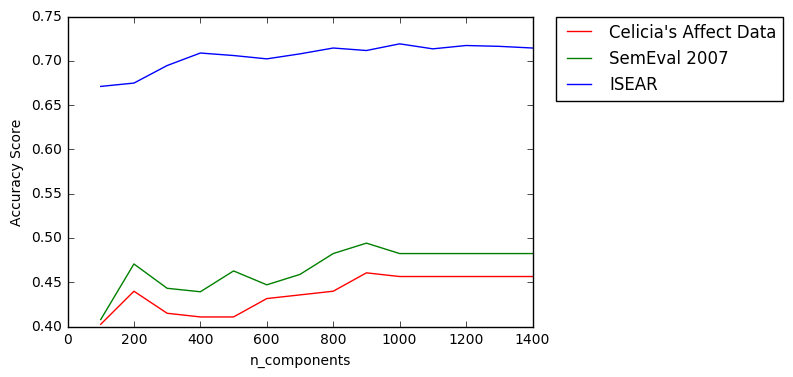

In [206]:
import matplotlib.pyplot as plt
%matplotlib inline  

x=np.arange(100, 1500, 100)
y=accuracy_list
plt.plot(x,accuracy_list1,'r', label="Celicia's Affect Data")
plt.plot(x, accuracy_list2, 'g', label='SemEval 2007')
plt.plot(x,accuracy_list3, 'b',label='ISEAR')
plt.ylabel('Accuracy Score')
plt.xlabel('n_components')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Apply SVM classifier of ISEAR dataset to detect emotion in Human of NY's stories.
There are 5 steps:
- Load Human of NY dataset into a list of stories (test_data)
- Data cleaning
- Load the SVM classifier using fitModel(df3,3,"df3_svm_3.pkl")
- Predict emotion of test_df
- Visualize the predicted data

# Human of NY Dataset
Load data from file humanofNY.txt (stories are separated by a new line)

In [21]:
test_data = [line.rstrip('\n') for line in open("T:/MSIM/LIS590TXL - Text Mining/Assignment/Final Project/Data Collection/humanofNY.txt")]

In [22]:
test_df = pd.DataFrame({'content': test_data})
test_df['sentiment']="NA"

In [23]:
#Clean content for test_df
test_df=contentCleaning(test_df)

In [24]:
#load svm classifier and apply to predict emotion in test_df['refined_content']
svm_clf = joblib.load("df3_svm_3.pkl")
predicted = svm_clf.predict(test_df['refined_content'])

In [25]:
test_df['sentiment']=predicted

In [26]:
test_df.groupby('sentiment').count()

,content,refined_content
sentiment,,
anger-disgust,139,139
fear,17,17
joy,21,21
sadness,15,15


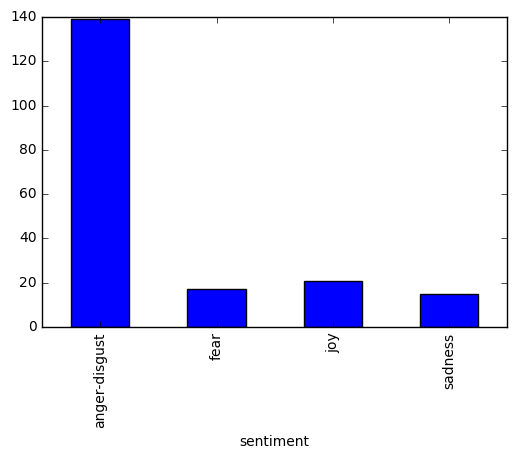

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline  

test_df.groupby('sentiment')['content'].count().plot(kind='bar')

In [28]:
test_df['storyno']=np.arange(1,len(test_df)+1)

In [29]:
test_df2=pd.concat([pd.Series(row['storyno'], row['content'].split('.'))              
                    for _, row in test_df.iterrows()]).reset_index()
test_df2.columns = ['content', 'storyno']
test_df2['sentiment']="NA"
test_df2=contentCleaning2(test_df2)
test_df2=test_df2[~test_df2['refined_content'].isin([""," "])]

In [30]:
predicted = svm_clf.predict(test_df2['refined_content'])

In [31]:
test_df2['sentiment']=predicted

In [32]:
test_df2.groupby(['storyno','sentiment']).count()

content  refined_content
storyno sentiment                              
1       anger-disgust        7                7
        fear                 1                1
        joy                  1                1
2       anger-disgust        4                4
        fear                 1                1
3       anger-disgust        7                7
4       anger-disgust       23               23
        fear                 4                4
        joy                  1                1
        sadness              2                2
5       anger-disgust        8                8
        fear                 5                5
        sadness              1                1
6       anger-disgust        6                6
        fear                 2                2
        joy                  5                5
        sadness              1                1
7       anger-disgust       14               14
        fear                 1                1
8       anger-disgust       12               12
        joy                  1                1
        sadness              1                1
9       anger-disgust        6                6
        joy                  1                1
        sadness              1                1
10      anger-disgust       13               13
        joy                  2                2
11      anger-disgust        9                9
        joy                  2                2
12      anger-disgust       11               11
...                        ...              ...
180     joy                  1                1
        sadness              1                1
181     anger-disgust       18               18
        fear                 1                1
        joy                  4                4
        sadness              1                1
182     anger-disgust        2                2
183     anger-disgust       12               12
        joy                  2                2
184     anger-disgust       14               14
        fear                 1                1
        joy                  1                1
        sadness              2                2
185     anger-disgust        2                2
186     anger-disgust       17               17
        fear                 1                1
        joy                  3                3
187     anger-disgust        6                6
        fear                 2                2
        sadness              1                1
188     anger-disgust        2                2
189     anger-disgust       11               11
        joy                  3                3
        sadness              3                3
190     anger-disgust       11               11
        fear                 1                1
191     anger-disgust        9                9
        fear                 5                5
        joy                  1                1
192     anger-disgust        1                1

[478 rows x 2 columns]

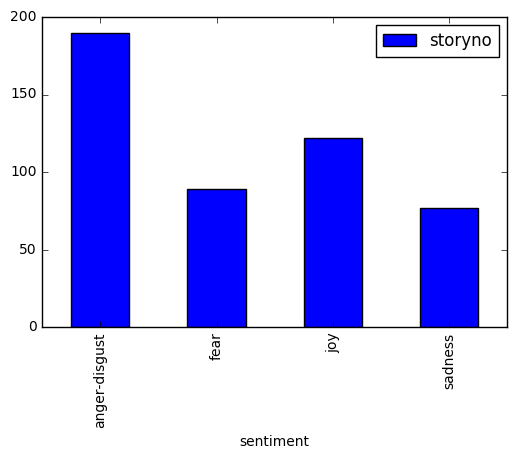

In [33]:
test_df2[['storyno','sentiment']].drop_duplicates().groupby('sentiment').count().plot(kind='bar')

In [117]:
#get the story number included in each emotion (for generating Venn diagram)
tmp_df=test_df2[['storyno','sentiment']].drop_duplicates()
allstories_set=set(np.arange(1,193))
angerdisgust_set=set(tmp_df[tmp_df['sentiment']=='anger-disgust']['storyno'])
fear_set=set(tmp_df[tmp_df['sentiment']=='fear']['storyno'])
joy_set=set(tmp_df[tmp_df['sentiment']=='joy']['storyno'])
sadness_set=set(tmp_df[tmp_df['sentiment']=='sadness']['storyno'])

In [122]:
#Find the stories do not have anger-disgust emotion.
allstories_set-angerdisgust_set

{20, 94}

In [123]:
#get the details of stories do not have anger-disgust emotion
test_df2[test_df2['storyno'].isin([20,94])]

,content,storyno,sentiment,refined_content
251,“He fell in love with me because I used to hav...,20,joy,fell love used huge as
1316,"“If I think back, I get depressed",94,sadness,think back get depressed
1317,"If I think ahead, I get afraid",94,fear,think ahead get afraid


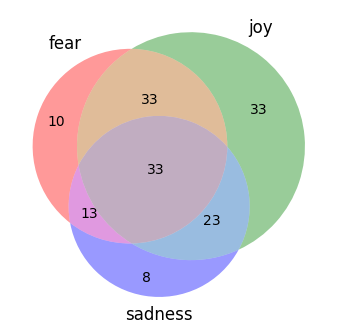

In [124]:
#venn diagram to show the intersection of fear, joy and sadness
from matplotlib_venn import venn3
venn3([ fear_set,joy_set,sadness_set], ( 'fear','joy','sadness'))

In [103]:
#spot check
test_df2.sample(15)

,content,storyno,sentiment,refined_content
1132,I was working as a security guard and my chil...,82,anger-disgust,working security guard child suffering
1164,Now we’ve spent the whole day together,84,joy,we’ve spent whole day together
2304,She would never respond when we tried to corr...,157,anger-disgust,would never respond tried correct
2273,And eleven hamsters,154,anger-disgust,eleven hamster
2328,“Ten years ago I lost my job at a hotel,159,sadness,ten year ago lost job hotel
234,I take the medicine because it’s part of the ...,18,anger-disgust,take medicine it’s part deal apartment i’m me...
2536,She was bleeding internally and had a blood c...,173,anger-disgust,bleeding internally blood clot leg
1798,For awhile I was so depressed that I couldn’t...,128,sadness,awhile depressed couldn’t leave room
233,But I’m not mentally ill,18,anger-disgust,i’m mentally ill
2754,I had to carry it up the hill,191,anger-disgust,carry hill
